In [1]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [23]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [3]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [197]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [198]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']
# conditions = ['0:1','1:3','1:1','3:1','1:0']
# conditions = ['0:1','1:3','1:1','3:1','1:0']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# UCM inputs

In [199]:
def COMPLEX(i,argument): #real or imag part of complex numbers
    if argument == 'real':
        return np.real(i) 
    elif argument == 'imag':
        return np.imag(i) 
    
def variances(signal0, siganl1, cond, argument = 'real'): 
    Sigma = np.cov(COMPLEX(np.array([signal0,siganl1]),argument))
    # projection vectors for each condition         
    if cond == 2: #emg = 0.5
        E_ORT = np.array([1,1])
        E_UCM = np.array([1,-1])
    elif cond == 1: #emg = 0.25
        E_ORT = np.array([1,3])
        E_UCM = np.array([3,-1])
    elif cond == 3: #emg = 0.75
        E_ORT = np.array([3,1])
        E_UCM = np.array([1,-3])
    else:
        print('condition not found')

    k = (np.linalg.norm(E_ORT))**2 #dimension of the subspace

    #variance in (UCM) and (OTH) directions
    variance_ucm = 1/k *(E_UCM.T@Sigma@E_UCM) #normalized by dimension of subspace
    variance_ort = 1/k *(E_ORT.T@Sigma@E_ORT)            

    return variance_ucm,variance_ort

## all frequency

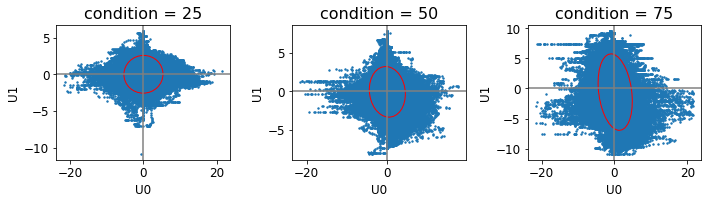

In [200]:
last_few_trials = 10
fig,axs = plt.subplots(1,3,figsize=(10,3))
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        dim0.append( (u0s[sub,cond,-last_few_trials:,:]) ) # time domain signals 
        dim1.append( (u1s[sub,cond,-last_few_trials:,:]) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    ax = axs[cond-1]
    ax.scatter(dim0,dim1,s = 2)
    confidence_ellipse(dim0,dim1, ax, edgecolor='red')
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(0.15,-0.15)
    # ax.set_ylim(0.15,-0.15)
    ax.set_xlabel('U0')
    ax.set_ylabel('U1')
    ax.set_title('condition = '+conditions[cond])  
plt.tight_layout()
plt.show()

## below crossover

In [201]:
print(xf[xf<=0.25])
print(xf[xf<=0.25].shape) # how many freqs below 0.25

print(xf[xf<=1])
print(xf[xf<=1].shape) # how many freqs below 1

# Machine at all freqs
M_all = soM(s(2*np.pi*xf_all)) #machine at all freqs #s = jw = j(2pif)  #2nd order machine
M_all[0] = 0
print(M_all)

# Machine inverse
M_all_inv = M_all**(-1)
M_all_inv[0] = 0
print(M_all_inv)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
(11,)
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]
(41,)
[ 0.        +0.j         -0.97592014-6.21290055j -0.91016984-2.89716057j
 ... -0.81828634+1.73645755j -0.91016984+2.89716057j
 -0.97592014+6.21290055j]
[ 0.        +0.j         -0.02467401+0.15707963j -0.09869604+0.31415927j
 ... -0.2220661 -0.4712389j  -0.09869604-0.31415927j
 -0.02467401-0.15707963j]


c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: divide by zero encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: invalid value encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-201-d983547de516>:13: RuntimeWarning: invalid value encountered in reciprocal
  M_all_inv = M_all**(-1)


<ipython-input-202-e1b1bd989b91>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices] - \
<ipython-input-202-e1b1bd989b91>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices] - \


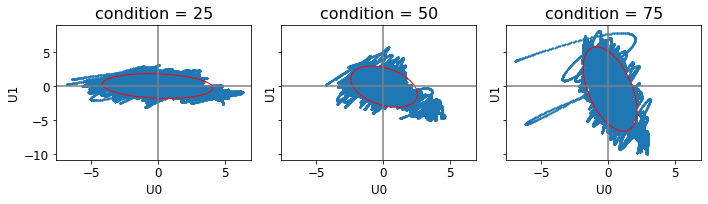

In [202]:
last_few_trials = 4 # cross trials
indices = np.arange(0,11) # indices below 0.25 Hz
fig,axs = plt.subplots(1,3,figsize=(10,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N))
        u1 = np.zeros((last_few_trials,N))
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices] - \
                                ((M_all_inv[indices]*Rs[sub,cond,-last_few_trials:,:][:,indices]- \
                                  Ds[sub,cond,-last_few_trials:,:][:,indices])/(alphas[cond]))
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices] - \
                                ((M_all_inv[indices]*Rs[sub,cond,-last_few_trials:,:][:,indices]- \
                                  Ds[sub,cond,-last_few_trials:,:][:,indices])/((1-alphas[cond])))
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    ax = axs[cond-1]
    ax.scatter(dim0,dim1,s = 0.5)
    confidence_ellipse(dim0,dim1, ax, edgecolor='red')
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(0.1,-0.1)
    # ax.set_ylim(0.1,-0.1)
    ax.set_xlabel('U0')
    ax.set_ylabel('U1')
    ax.set_title('condition = '+conditions[cond])  
plt.tight_layout()
plt.show()

## stimulated freqs below crossover

<ipython-input-204-a629e2f3df53>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = U0s[sub,cond,trials,:][:,indices] - \
<ipython-input-204-a629e2f3df53>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = U1s[sub,cond,trials,:][:,indices] - \


UCM =  0.5928600834927962 , ORT =  0.7239279635992302
UCM =  0.14464271003882528 , ORT =  0.833993465614039
UCM =  2.081324881874608 , ORT =  0.983438300769759


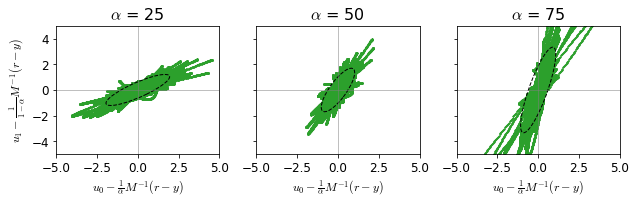

In [204]:
# last_few_trials = 4 # cross trials
# trials = [0,2,4,6,8,10,12]
# trials = [1,3,5,7,9,11,13]
trials = np.arange(0,trial_num)[-4:] # last 4 trials
indices = IX[:2] # indices below 0.25 Hz
fig,axs = plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((len(trials),N))
        u1 = np.zeros((len(trials),N))
        u0[:,indices] = U0s[sub,cond,trials,:][:,indices] - \
                                ((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
                                  Ys[sub,cond,trials,:][:,indices]))/(alphas[cond]))
        u1[:,indices] = U1s[sub,cond,trials,:][:,indices] - \
                                ((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
                                  Ys[sub,cond,trials,:][:,indices]))/((1-alphas[cond])))
        # u0[:,indices] = U0s[sub,cond,trials,:][:,indices] - \
        #                         ((M_all_inv[indices]*Rs[sub,cond,trials,:][:,indices]- \
        #                           Ds[sub,cond,trials,:][:,indices])/(alphas[cond]))
        # u1[:,indices] = U1s[sub,cond,trials,:][:,indices] - \
        #                         ((M_all_inv[indices]*Rs[sub,cond,trials,:][:,indices]- \
        #                           Ds[sub,cond,trials,:][:,indices])/((1-alphas[cond])))
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    ax = axs[cond-1]
    ax.scatter(dim0,dim1,s = 0.5,color = colors['GREEN'])
    confidence_ellipse(dim0,dim1, ax, edgecolor='black',linestyle = '--')
    variance_ucm,variance_ort = variances(dim0,dim1,cond = cond, argument = 'real')
    print('UCM = ',variance_ucm,', ORT = ',variance_ort)
    ax.axvline(x = 0,color = 'grey',linewidth = 0.5)
    ax.axhline(y = 0,color = 'grey',linewidth = 0.5)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel(r'$u_0 - \frac{1}{\alpha}M^{-1}(r-y)$')
    
    ax.set_title(r'$\alpha$ = '+conditions[cond])  
axs[0].set_ylabel(r'$u_1 - \frac{1}{1-\alpha}M^{-1}(r-y)$')
plt.tight_layout()
plt.show()

## non-stim freq below crossover

<ipython-input-209-56e6519501a1>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
<ipython-input-209-56e6519501a1>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]


UCM =  3.0686747609765535 , ORT =  0.10686960351122184
UCM =  2.3836134005463254 , ORT =  0.12051922342596064
UCM =  7.497222710868097 , ORT =  0.13689016494862552


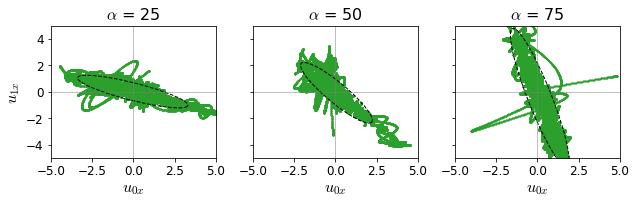

In [209]:
last_few_trials = 4 # cross trials 
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
fig,axs = plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N))
        u1 = np.zeros((last_few_trials,N))
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    ax = axs[cond-1]
    ax.scatter(dim0,dim1,s = 0.5,color = colors['GREEN'])
    confidence_ellipse(dim0,dim1, ax, edgecolor='black',linestyle = '--')
    variance_ucm,variance_ort = variances(dim0,dim1,cond = cond, argument = 'real')
    print('UCM = ',variance_ucm,', ORT = ',variance_ort)
    ax.axvline(x = 0,color = 'grey',linewidth = 0.5)
    ax.axhline(y = 0,color = 'grey',linewidth = 0.5)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel(r'$u_{0x}$',fontsize = 16)
    ax.set_title(r'$\alpha$ = '+conditions[cond]) 
axs[0].set_ylabel(r'$u_{1x}$',fontsize = 16)
# fig.suptitle('Inputs at on-stimulus frequencies')
plt.tight_layout()
plt.show()

## together

In [210]:
# stimulated
indices = IX[:2] # indices below 0.25 Hz
xdim = []
ydim = []
for cond in [1,2,3]: 
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((len(trials),N))
        u1 = np.zeros((len(trials),N))
        u0[:,indices] = U0s[sub,cond,trials,:][:,indices] - \
                                ((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
                                  Ys[sub,cond,trials,:][:,indices]))/(alphas[cond]))
        u1[:,indices] = U1s[sub,cond,trials,:][:,indices] - \
                                ((M_all_inv[indices]*(Rs[sub,cond,trials,:][:,indices]- \
                                  Ys[sub,cond,trials,:][:,indices]))/((1-alphas[cond])))
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    xdim.append(dim0)
    ydim.append(dim1)
xdim = np.array(xdim)
ydim = np.array(ydim)    

#nonstimulated
indices = np.setdiff1d(np.arange(0,11), IX) # non-stimulus freqs below 0.25hz 
xdim_ = []
ydim_ = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N))
        u1 = np.zeros((last_few_trials,N))
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    xdim_.append(dim0)
    ydim_.append(dim1)
xdim_ = np.array(xdim_)
ydim_ = np.array(ydim_)   

<ipython-input-210-b49c2870f3d7>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = U0s[sub,cond,trials,:][:,indices] - \
<ipython-input-210-b49c2870f3d7>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = U1s[sub,cond,trials,:][:,indices] - \
<ipython-input-210-b49c2870f3d7>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
<ipython-input-210-b49c2870f3d7>:40: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]


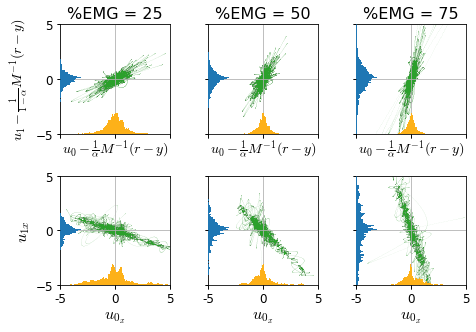

In [221]:
rcParams['mathtext.fontset'] = 'cm'
font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row', figsize=(7,4.75))

PLOT0 = [xdim,xdim_]
PLOT1 = [ydim,ydim_]
titles = ['%EMG = 25','%EMG = 50','%EMG = 75']
condition_order = [1,2,3]
major_ticks = [-4,-2,0,2,4]
major_ticks = [-5,0,5]

# definitions for the axes
left, width = 0,1
bottom, height = 0,1
hist_height = 0.2 #historgram bin height
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom , width, hist_height]
rect_histy = [left, bottom, hist_height, height]

for i in range(2): #rows
    for j in range(3): #cols
        ax = axs[i,j]
        c = condition_order[j]
        x = np.array(PLOT0[i][j])
        y = np.array(PLOT1[i][j])
        # confidence_ellipse(x,y, ax, edgecolor='red')

        ax.scatter(x,y,color = colors['GREEN'], s=0.1,label = 'condition'+str(c),alpha = 0.01)

        #histograms
        ax_histx = ax.inset_axes(rect_histx, sharex=ax)
        ax_histy = ax.inset_axes(rect_histy, sharey=ax)
        # no labels
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)

        # now determine nice limits by hand:
        binwidth = 0.1
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        bins = np.arange(-lim, lim + binwidth, binwidth)
        if c != 5:
            ax_histx.hist(x, bins=bins,color=colors['GOLD'])
        if c != 6:
            ax_histy.hist(y, bins=bins, orientation='horizontal',color=colors['BLUE'])

        # ax.set_facecolor('none')
        ax_histx.set_facecolor('none')
        ax_histy.set_facecolor('none')

        ax_histx.spines['top'].set_visible(False)
        ax_histx.spines['right'].set_visible(False)
        ax_histx.spines['bottom'].set_visible(False)
        ax_histx.spines['left'].set_visible(False)
        ax_histy.spines['top'].set_visible(False)
        ax_histy.spines['right'].set_visible(False)
        ax_histy.spines['bottom'].set_visible(False)
        ax_histy.spines['left'].set_visible(False)

        ax_histx.set(yticks=[])
        ax_histy.set(xticks=[])
        ax.set_aspect('equal')
        ax.grid()
        ax.set_xticks(major_ticks)
        ax.set_xticklabels(major_ticks) 
    axs[i,0].set_yticks(major_ticks)

for j in range(3): #cols
    axs[0,j].title.set_text(titles[j])
    axs[0,j].set_xlabel(r'$u_0 - \frac{1}{\alpha}M^{-1}(r-y)$',fontsize = 14)
    axs[1,j].set_xlabel(r'$u_{0_x}$',fontsize = 16)

    axs[0,j].set_xlim(-5,5)
    axs[0,j].set_ylim(-5,5)
    axs[1,j].set_xlim(-5,5)
    axs[1,j].set_ylim(-5,5)
    
axs[0,0].set_ylabel(r'$u_1 - \frac{1}{1-\alpha}M^{-1}(r-y)$',fontsize = 14)
axs[1,0].set_ylabel(r'$u_{1x}$',fontsize = 16)
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
plt.tight_layout()
# fig.savefig('ucm.svg')
plt.savefig("ucm.png")
plt.show()

## u0 and u1

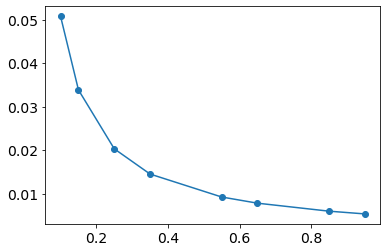

In [97]:
Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Rs[0,0,-1,IX][::2]
Stimuli[1::2] = Rs[0,0,-2,IX][1::2]

plt.plot(freqs,np.abs(Stimuli),'-o')

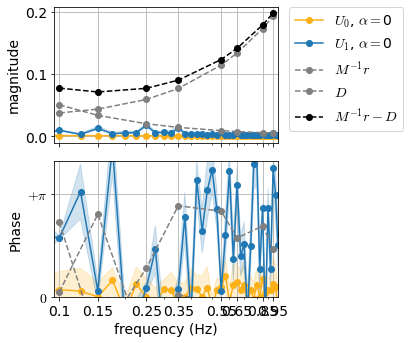

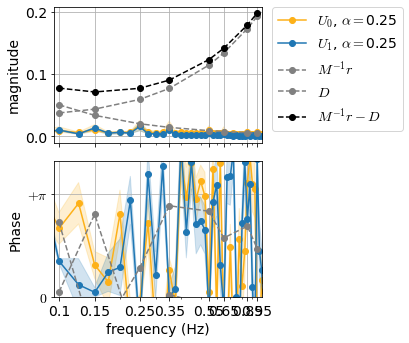

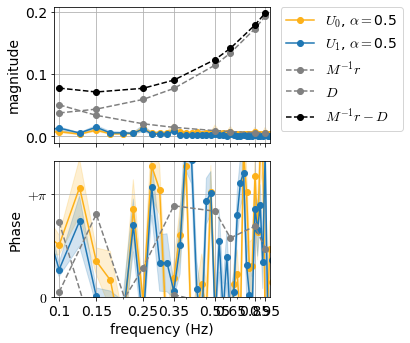

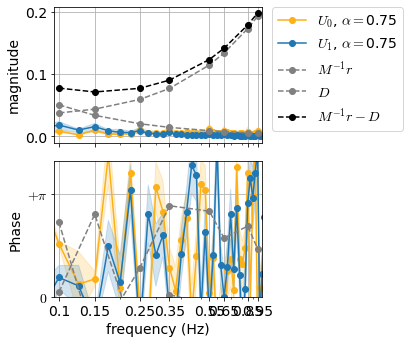

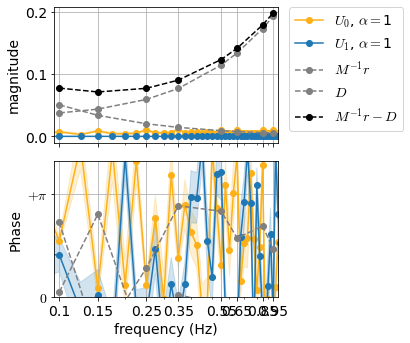

In [122]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))

    # U0
    mean = np.mean(np.abs(U0s[:,cond,:,:N//2]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(xf,q50,'-o',label = r'$U_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(xf, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    angle = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,:,:N//2]))),axis = 1))
    z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(xf,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(xf,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # U1
    F_mean = np.mean(np.abs(U1s[:,cond,:,:N//2]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(xf,q50,'-o',label = r'$U_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(xf, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,:,:N//2]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(xf,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(xf,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(Stimuli/M),'--o',color= 'grey',label = r'$M^{-1}r$')
    ax.plot(freqs,np.abs(Stimuli),'--o',color= 'grey',label = r'$D$')
    ax.plot(freqs,np.abs(Stimuli/M - Stimuli),'--o',color= 'black',label = r'$M^{-1}r - D$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    # ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(Stimuli/M),'--o',color= 'grey',label = r'$M^{-1}r$')
    ax.plot(freqs,np.angle(Stimuli),'--o',color= 'grey',label = r'$D$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# UCM FF

9.630979501739928 3.8275791365361886
3.0412400725827107 5.447883010133714
11.765388354074636 4.7338507952347655


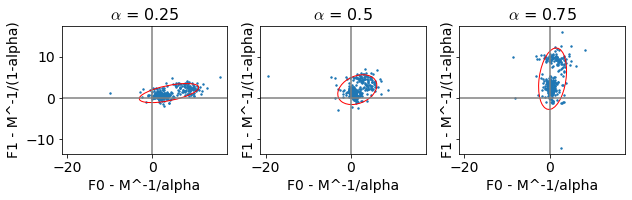

In [ ]:
last_few_trials = 5 # cross trials (N//2)
fig,axs = plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    xdim = []
    ydim = []
    for i in range(3): # lowest 3 stim freqs
        dim0 = []
        dim1 = []
        for sub in range(subject_num):
            dim0.append( (F0[sub,cond,:,i]-(M**(-1))[i]/alphas[cond]) )
            dim1.append( (F1[sub,cond,:,i]-(M**(-1))[i]/(1-alphas[cond])) )
            # dim0.append( (F0[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            # dim1.append( (F1[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            # dim0.append( (F0[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
            # dim1.append( (F1[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
        xdim.append(np.array(dim0).flatten())
        ydim.append(np.array(dim1).flatten())
    xdim = np.concatenate(xdim)
    ydim = np.concatenate(ydim)
    ax = axs[cond-1]
    ax.scatter(xdim,ydim,s = 2)
    confidence_ellipse(xdim,ydim, ax, edgecolor='red',n_std=2.0)
    variance_ucm,variance_ort = variances(xdim,ydim,cond = cond, argument = 'real')
    print(variance_ucm,variance_ort)
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2)
    ax.set_xlabel('F0 - M^-1/alpha')
    ax.set_ylabel('F1 - M^-1/(1-alpha)')
    ax.set_title(r'$\alpha$ = '+conditions[cond]) 
plt.tight_layout()
plt.show()

In [ ]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N))
        u1 = np.zeros((last_few_trials,N))
        u0[:,indices] = U0s[sub,cond,-last_few_trials:,:][:,indices]
        u1[:,indices] = U1s[sub,cond,-last_few_trials:,:][:,indices]
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()

<ipython-input-152-7ba1d52715ae>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  u0[:,indices] = F0[sub,cond,trial,:3]*M[:3]*Rs[sub,cond,trial,:3] - Ys[sub,cond,trial,:3]/alphas[cond]
<ipython-input-152-7ba1d52715ae>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  u1[:,indices] = F1[sub,cond,trial,:3]*M[:3]*Rs[sub,cond,trial,:3] - Ys[sub,cond,trial,:3]/(1-alphas[cond])


0.038293722985711806 0.021540219179462857
0.0 0.02006922083349072
0.18526675043753402 0.10421254712111312


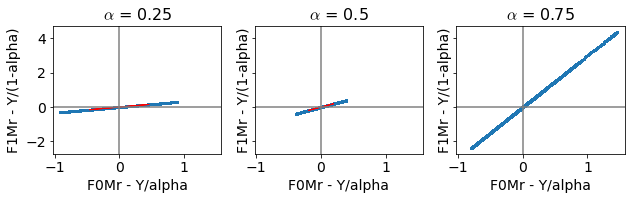

In [152]:
# last_few_trials = 5 # cross trials (N//2)
trial = -1
indices = IX[:3] # lowest 3 stim freqs
fig,axs = plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = np.zeros((last_few_trials,N))
        u1 = np.zeros((last_few_trials,N))
        u0[:,indices] = F0[sub,cond,trial,:3]*M[:3]*Rs[sub,cond,trial,:3] - Ys[sub,cond,trial,:3]/alphas[cond]
        u1[:,indices] = F1[sub,cond,trial,:3]*M[:3]*Rs[sub,cond,trial,:3] - Ys[sub,cond,trial,:3]/(1-alphas[cond])
        # conjegate symmetry
        u0[:,-indices] = np.conjugate(u0[:,indices])
        u1[:,-indices] = np.conjugate(u1[:,indices])
        dim0.append( IFFT(u0,N) )
        dim1.append( IFFT(u1,N) )
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    ax = axs[cond-1]
    ax.scatter(dim0,dim1,s = 2)
    confidence_ellipse(dim0,dim1, ax, edgecolor='red',n_std=2.0)
    variance_ucm,variance_ort = variances(dim0,dim1,cond = cond, argument = 'real')
    print(variance_ucm,variance_ort)
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2)
    ax.set_xlabel('F0Mr - Y/alpha')
    ax.set_ylabel('F1Mr - Y/(1-alpha)')
    ax.set_title(r'$\alpha$ = '+conditions[cond]) 
plt.tight_layout()
plt.show()

4.743713734545366 1.7912069234902166
4.369508666726164 4.202155344808112
3.9959421699999815 8.115855167786172


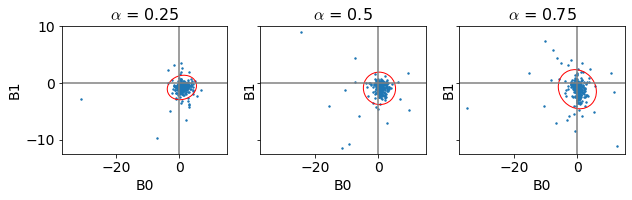

In [140]:
last_few_trials = 5 # cross trials (N//2)
fig,axs = plt.subplots(1,3,figsize=(9,3),sharex=True,sharey=True)
for cond in [1,2,3]:
    xdim = []
    ydim = []
    for i in range(3): # lowest 3 stim freqs
        dim0 = []
        dim1 = []
        for sub in range(subject_num):
            dim0.append( B0[sub,cond,:,i].imag )
            dim1.append( B1[sub,cond,:,i].imag )
            # dim0.append( (F0[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            # dim1.append( (F1[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            # dim0.append( (F0[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
            # dim1.append( (F1[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
        xdim.append(np.array(dim0).flatten())
        ydim.append(np.array(dim1).flatten())
    xdim = np.concatenate(xdim)
    ydim = np.concatenate(ydim)
    ax = axs[cond-1]
    ax.scatter(xdim,ydim,s = 2)
    confidence_ellipse(xdim,ydim, ax, edgecolor='red',n_std=2.0)
    variance_ucm,variance_ort = variances(xdim,ydim,cond = cond, argument = 'real')
    print(variance_ucm,variance_ort)
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2)
    ax.set_xlabel('B0')
    ax.set_ylabel('B1')
    ax.set_title(r'$\alpha$ = '+conditions[cond]) 
plt.tight_layout()
plt.show()